# Neutrino oscillations - part 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import chi2

In [3]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy) 

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    data = []

    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            data.append([e, c, events[i]])
            i=i+1
        
    df = pd.DataFrame(data, columns = ['Energy','cosdec','Events'])
                   
    return df

In [4]:
# lets generate one experiment, with 10 energy bins and 10 cos(declination) bins

cosdec =  np.linspace(0, 1, 10) # 10 steps in cos(declination) from 0 to 1 
log10_energy = np.linspace(1, 2, 10) # 10 steps in log10(energy) from 10 to 100 GeV
energy=10**log10_energy

# run the experiment 
events=run_experiment(energy,cosdec,0.9,2.4e-3)

def generate_experiment(N=1):
    cosdec =  np.linspace(0, 1, 10) # 10 steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, 10) # 10 steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy

    
    experiments = []
    
    if N == 1:
        events = run_experiment(energy, cosdec, 0.9, 2.4e-3)
        return events
    else:
        for i in range(N):
            events = run_experiment(energy, cosdec, 0.9, 2.4e-3)
            experiments.append(events)
        
        return experiments

In [5]:
generate_experiment()

,Energy,cosdec,Events
0,10.0,0.000000,1938.0
1,10.0,0.111111,1280.0
2,10.0,0.222222,680.0
3,10.0,0.333333,323.0
4,10.0,0.444444,182.0
...,...,...,...
95,100.0,0.555556,38.0
96,100.0,0.666667,31.0
97,100.0,0.777778,36.0
98,100.0,0.888889,31.0


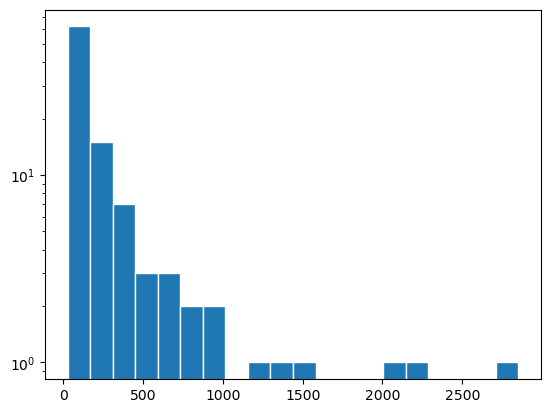

In [6]:
ex_1 = generate_experiment()

plt.hist(ex_1["Events"], bins = 20, edgecolor = 'w')
plt.yscale('log')
plt.show()    

## Part 2. starts from here

### First, build a function to be the model 

In [7]:
def fit_func(sin2theta, dm2):
    cosdec =  np.linspace(0, 1, 10) # 10 steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, 10) # 10 steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy
    
    f = []
    
    for e in energy:
        for c in cosdec:
            fi = atmo_event_rate(e, c, sin2theta, dm2)
            f.append([e, c, int(fi)])
            
    df = pd.DataFrame(f, columns = ['Energy','cosdec','Events'])
            
    return df

In [8]:
func = fit_func(0.9, 2.4e-3)

### Second, build function to calculate chi2 

In [66]:
def chi_s(ex_1, func):
    chi_list = []
    s = np.sum((ex_1["Events"]-func["Events"])**2/func["Events"])
    return s

Run trial 1000 times and collect the chi2 value, giving a list

In [67]:
chis_list = np.zeros(1000)
for i in range(1000):
    ex = generate_experiment()
    chis_list[i] = chi_s(ex, func)

In [68]:
chis_list = np.array(chis_list)

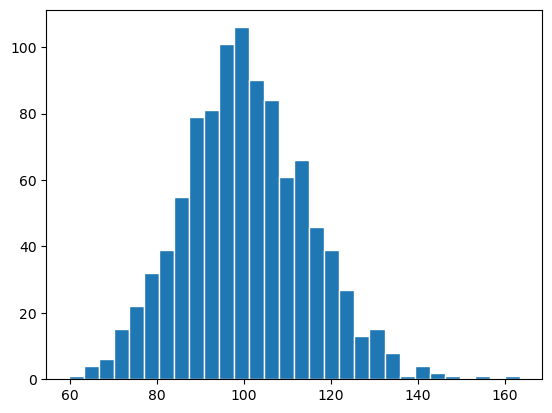

In [69]:
plt.hist(chis_list, bins = 30, edgecolor = 'w')
plt.show()   

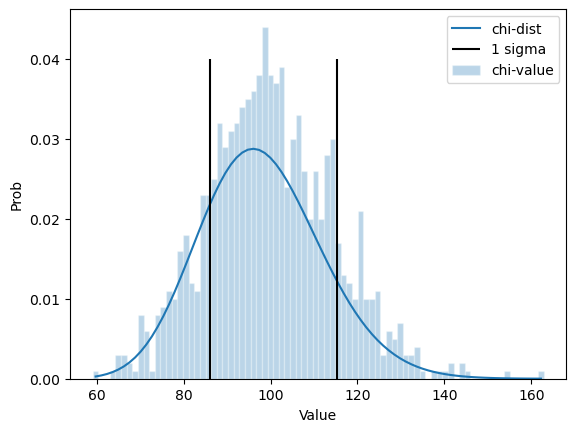

In [70]:
df =98
high, widt = np.histogram(chis_list, bins=80)
high = high/np.sum(high)

# the chi2 distribution function
chi2_dis = scipy.stats.chi2.pdf(widt[:-1], df=df)

plt.bar(widt[:-1], high, width = widt[1]-widt[0], edgecolor = 'w', alpha = 0.3,  label = "chi-value")
plt.plot(widt[:-1], chi2_dis,  label = "chi-dist")

plt.vlines([np.mean(chis_list) + np.std(chis_list), np.mean(chis_list) - np.std(chis_list)], 0, 0.04, color = 'black', label="1 sigma", ls="-")
plt.xlabel("Value")
plt.ylabel("Prob")
plt.legend()
plt.show()
plt.show()   

### Third, print seperately mean, std and var of trial's events and chi2 distribution

In [71]:
# mean, std, var of events values
print(f"mean of chi square values: {np.mean(chis_list):.2f}")
print(f"std. dev of chi square values: {np.std(chis_list):.2f}")
print(f"variance of chi square values: {np.var(chis_list):.2f}")

mean of chi square values: 100.65
std. dev of chi square values: 14.54
variance of chi square values: 211.48


In [72]:
# mean, std, var of chi2 distribution
mean, var, skew, kurt = chi2.stats(df, moments='mvsk')
print(f"mean of chi square distribution values: {mean:.2f}")
print(f"std. of chi square distribution values: {np.sqrt(var):.2f}")
print(f"variance of chi square distribution values: {var:.2f}")

mean of chi square distribution values: 98.00
std. of chi square distribution values: 14.00
variance of chi square distribution values: 196.00


### last, to find the chi2 value corr to cumulative 67% of dis

In [73]:
chis_sort = np.sort(chis_list)
df = pd.DataFrame(chis_sort, columns = ['Events'])

In [74]:
df

,Events
0,59.768851
1,64.946829
2,65.070680
3,65.319190
4,65.558787
...,...
995,144.238782
996,145.305292
997,146.472661
998,154.448284


In [75]:
for i in range(len(chis_sort)):
    val = (i+1)/len(chis_sort)
    if val == 0.670:
        record = chis_sort[i]
        print(record-chis_sort[0])

46.61890975460806


In [76]:
print(f"chi square value corr. o cumulative 67% of dis : {record:.2f}")
print(f"delta chi square value: {record-chis_sort[0]:.2f}")

chi square value corr. o cumulative 67% of dis : 106.39
delta chi square value: 46.62
